In [1]:
import m2mcluster as m2m

In [2]:
from amuse.lab import *
from amuse.units import nbody_system,units
from amuse.community.bhtree.interface import BHTree

import matplotlib.pyplot as plt
import numpy as np


In [3]:
#Setup a star cluster for artificial observation
ocluster=m2m.setup_star_cluster(N=1000, Mcluster = 1000 | units.MSun, Rcluster = 9. |units.parsec, W0=7.)

#Measure artifical cluster's density profile asssuming an equal number of stars per bin
orlower,orad,orupper,orho=m2m.density(ocluster,bins=True,bintype='fix')

In [4]:
#Initialize an M2M Star cluster
#Specify number of iterations to run algorithm for
#Specify number of workers to be used by Nbody code
cluster=m2m.starcluster(number_of_iterations=1,number_of_workers=1)

In [5]:
#Add the "observed" cluster density profile as an observable
cluster.add_observable(orlower,orad,orupper,orho,'density',2)

In [6]:
#Initialize a model star cluster will an initial guess as the observed cluster's properties
cluster.initialize_star_cluster(N=1000, Mcluster = 1000 | units.MSun, Rcluster = 3. |units.parsec, softening = 0.75 | units.parsec, W0=1.)

(<amuse.datamodel.particles.Particles at 0x13f0c3f40>,
 <amuse.units.nbody_system.nbody_to_si at 0x13f180970>)

In [7]:
#Plot initial positions
cluster.xy_plot(filename='xyplot0.png')

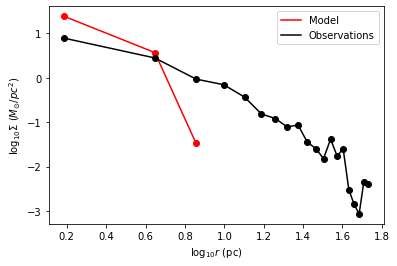

In [8]:
#Compare initial density profiles
#cluster.rho_prof(filename='rhoplot0.png')
cluster.rho_prof()

In [9]:
#Exectute the made to measure algorithm
outfile=open('logfile','w')
for i in range(0,cluster.number_of_iterations):
    #Initialize a new N-body simulation ever time step. 
    #In this example I use 1% of the cluster's dynamical time for the integration timeste
    cluster.initialize_gravity_code('BHTree', dt=0.01*cluster.tdyn)
    #Evolve the model cluster forward for 10% of its dynamical time
    cluster.evolve(tend=0.1*cluster.tdyn)
    #Run the M2M algorithm, which will adjust all of the stellar masses based on kernel function
    cluster.evaluate(kernel='gaussian',m2mepsilon=1.0e-3,plot=False,sigma=0.2)
    #Compare the new model density profile to the observed one
    cluster.rho_prof(filename='%s.png' % str(i).zfill(5))
    #Centre the star cluster and find determine Nbody conversion scales for next integration
    cluster.reinitialize_star_cluster()

    outfile.write('%i %f\n' % (i,cluster.criteria))
outfile.close()

0  TIME UNITS:  0.244963929474 Myr


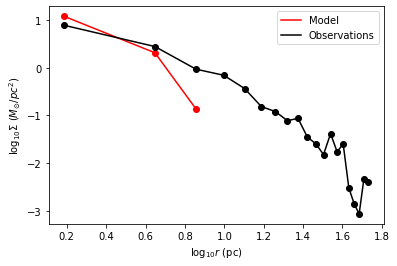

In [10]:
cluster.rho_prof()